In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

In [26]:
#extract processed data
df = pd.read_csv("processed_data.csv")

#remove extreme high correlation varaibles and unrelated variables 
df.drop(['ANNMILES', 'GASUSGE', ], axis=1, inplace=True)

#separate prediction variable and id from dataframe
df_y = df.pop('SuperUser')
id = df.pop("HOUSEID")

#create train and test dataset
x_train, x_test, y_train, y_test = train_test_split(df, df_y, test_size=0.2)

#(df.columns)

In [27]:
y_train.value_counts()

SuperUser
0    5167
1     565
Name: count, dtype: int64

In [28]:
print(y_train.value_counts())

SuperUser
0    5167
1     565
Name: count, dtype: int64


In [29]:
x = pd.concat([x_train, y_train], axis=1)
non_superuser = x[x.SuperUser == 0]
superuser = x[x.SuperUser == 1]
superuser_upsampled = resample(superuser, replace=True, n_samples = len(non_superuser), random_state=42)
upsampled = pd.concat([non_superuser,superuser_upsampled])
up_y_train = upsampled.SuperUser
up_x_train = upsampled.drop('SuperUser', axis=1)
up_y_train.value_counts()


SuperUser
0    5167
1    5167
Name: count, dtype: int64

In [30]:
non_superuser_downsampled = resample(non_superuser, replace = False, n_samples = len(superuser), random_state=42)
downsampled = pd.concat([non_superuser_downsampled, superuser])
d_y_train = downsampled.SuperUser
d_x_train = downsampled.drop('SuperUser', axis=1)
d_y_train.value_counts()

SuperUser
0    565
1    565
Name: count, dtype: int64

Due to data being imbalanced in nonsuperuser vs superuser, KNN is not suited

In [9]:
knn = KNeighborsClassifier(n_neighbors=5)
#knn.fit(x_train, y_train)
#knn.fit(up_x_train, up_y_train)
knn.fit(d_x_train, d_y_train)

y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print('Confusion matrix')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))


Accuracy: 60.11%
ROCAUC: 55.24%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.61      0.73      1279
           1       0.13      0.49      0.21       155

    accuracy                           0.60      1434
   macro avg       0.52      0.55      0.47      1434
weighted avg       0.82      0.60      0.68      1434

Confusion matrix
     0    1
0  786  493
1   79   76


In [70]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=25, min_samples_split = 25,
                             max_features= 'sqrt',
                             class_weight={0:0.1, 1:0.9},
                             #class_weight = 'balanced'
                            )

x, y = x_train, y_train
#x, y = up_x_train, up_y_train
#x, y = d_x_train, d_y_train

y = y.reset_index(drop=True)
x = x.reset_index(drop=True)

rfc.fit(x, y)
test_pred = rfc.predict(x)

print("Train data accuracy report:")
accuracy = accuracy_score(y, test_pred)
roc_score = roc_auc_score(y, test_pred)
class_report = classification_report(y, test_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y, test_pred)), '\n')



Train data accuracy report:
ROCAUC: 77.45%
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      5167
           1       0.33      0.70      0.45       565

    accuracy                           0.83      5732
   macro avg       0.65      0.77      0.68      5732
weighted avg       0.90      0.83      0.86      5732

      0    1
0  4364  803
1   167  398 



In [71]:
y_pred = rfc.predict(x_test)

print("Test data accuracy report:")
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print()
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print()

Test data accuracy report:
ROCAUC: 61.60%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.83      0.87      1282
           1       0.22      0.40      0.28       152

    accuracy                           0.79      1434
   macro avg       0.57      0.62      0.58      1434
weighted avg       0.85      0.79      0.81      1434


      0    1
0  1065  217
1    91   61



In [72]:
plt.figure(figsize=(15,20), dpi=1000)
plot_tree(rfc.estimators_[0], 
          feature_names=df.columns[:-1],
          class_names=[str(c) for c in df_y.unique()],
          filled= True
          )


[Text(0.547316384180791, 0.96875, 'LIF_CYC <= 8.5\ngini = 0.5\nsamples = 3586\nvalue = [517.8, 498.6]\nclass = 0'),
 Text(0.3057909604519774, 0.90625, 'URBANSIZE <= 1.5\ngini = 0.493\nsamples = 2127\nvalue = [295.3, 371.7]\nclass = 1'),
 Text(0.1638418079096045, 0.84375, 'HHVEHCNT <= 0.48\ngini = 0.468\nsamples = 763\nvalue = [101.6, 170.1]\nclass = 1'),
 Text(0.11299435028248588, 0.78125, 'NewEngland <= 0.5\ngini = 0.5\nsamples = 505\nvalue = [71.5, 68.4]\nclass = 0'),
 Text(0.1016949152542373, 0.71875, 'WALKTRANSIT <= -0.448\ngini = 0.5\nsamples = 474\nvalue = [66.3, 68.4]\nclass = 1'),
 Text(0.05649717514124294, 0.65625, 'DRVRCNT <= -0.407\ngini = 0.479\nsamples = 263\nvalue = [33.7, 51.3]\nclass = 1'),
 Text(0.03389830508474576, 0.59375, 'URBANSIZE <= 0.5\ngini = 0.5\nsamples = 101\nvalue = [14.0, 13.5]\nclass = 0'),
 Text(0.022598870056497175, 0.53125, 'WTHHFIN5D <= -0.171\ngini = 0.449\nsamples = 73\nvalue = [10.5, 5.4]\nclass = 0'),
 Text(0.011299435028248588, 0.46875, 'gini = 0

In [73]:
#"""
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers

model = Sequential()
model.add(Dense(128, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(64, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(36, input_dim=x.shape[1], activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['binary_crossentropy'])

a_weight = y.value_counts()[1]/y.value_counts()[0]
b_weight = 1-y.value_counts()[1]/y.value_counts()[0]

history = model.fit(x,y, class_weight={0:a_weight, 1:b_weight}, epochs=10, verbose=1)

rfc.fit(x, y)
print("Train data accuracy report:")
accuracy = accuracy_score(y, test_pred)
roc_score = roc_auc_score(y, test_pred)
class_report = classification_report(y, test_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print(pd.DataFrame(confusion_matrix(y, test_pred)), '\n')
#"""


Epoch 1/10


c:\Users\Jianwei\anaconda3\envs\python-ml\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - binary_crossentropy: 0.6418 - loss: 0.1633
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - binary_crossentropy: 0.6259 - loss: 0.1529
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - binary_crossentropy: 0.6416 - loss: 0.1526
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - binary_crossentropy: 0.6430 - loss: 0.1556
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - binary_crossentropy: 0.6298 - loss: 0.1538
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - binary_crossentropy: 0.6378 - loss: 0.1489
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - binary_crossentropy: 0.6356 - loss: 0.1489
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - binary_crossentropy: 0.6230 - loss: 0.1528
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - binary_crossentropy: 0.6099 - loss: 0.1481
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - binary_crossentropy: 0.6195 - loss: 0.1434
Train data accuracy 

In [17]:
"""
y_pred = model.predict(x_test)
y_pred = np.array([1 if x>=0.5 else 0 for x in y_pred])
accuracy = accuracy_score(y_test, y_pred)
roc_score = roc_auc_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
#print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROCAUC: {roc_score * 100:.2f}%")
print("Classification Report:\n", class_report)
print()
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print()
"""

'\ny_pred = model.predict(x_test)\ny_pred = np.array([1 if x>=0.5 else 0 for x in y_pred])\naccuracy = accuracy_score(y_test, y_pred)\nroc_score = roc_auc_score(y_test, y_pred)\nclass_report = classification_report(y_test, y_pred)\n#print(f"Accuracy: {accuracy * 100:.2f}%")\nprint(f"ROCAUC: {roc_score * 100:.2f}%")\nprint("Classification Report:\n", class_report)\nprint()\nprint(pd.DataFrame(confusion_matrix(y_test, y_pred)))\nprint()\n'

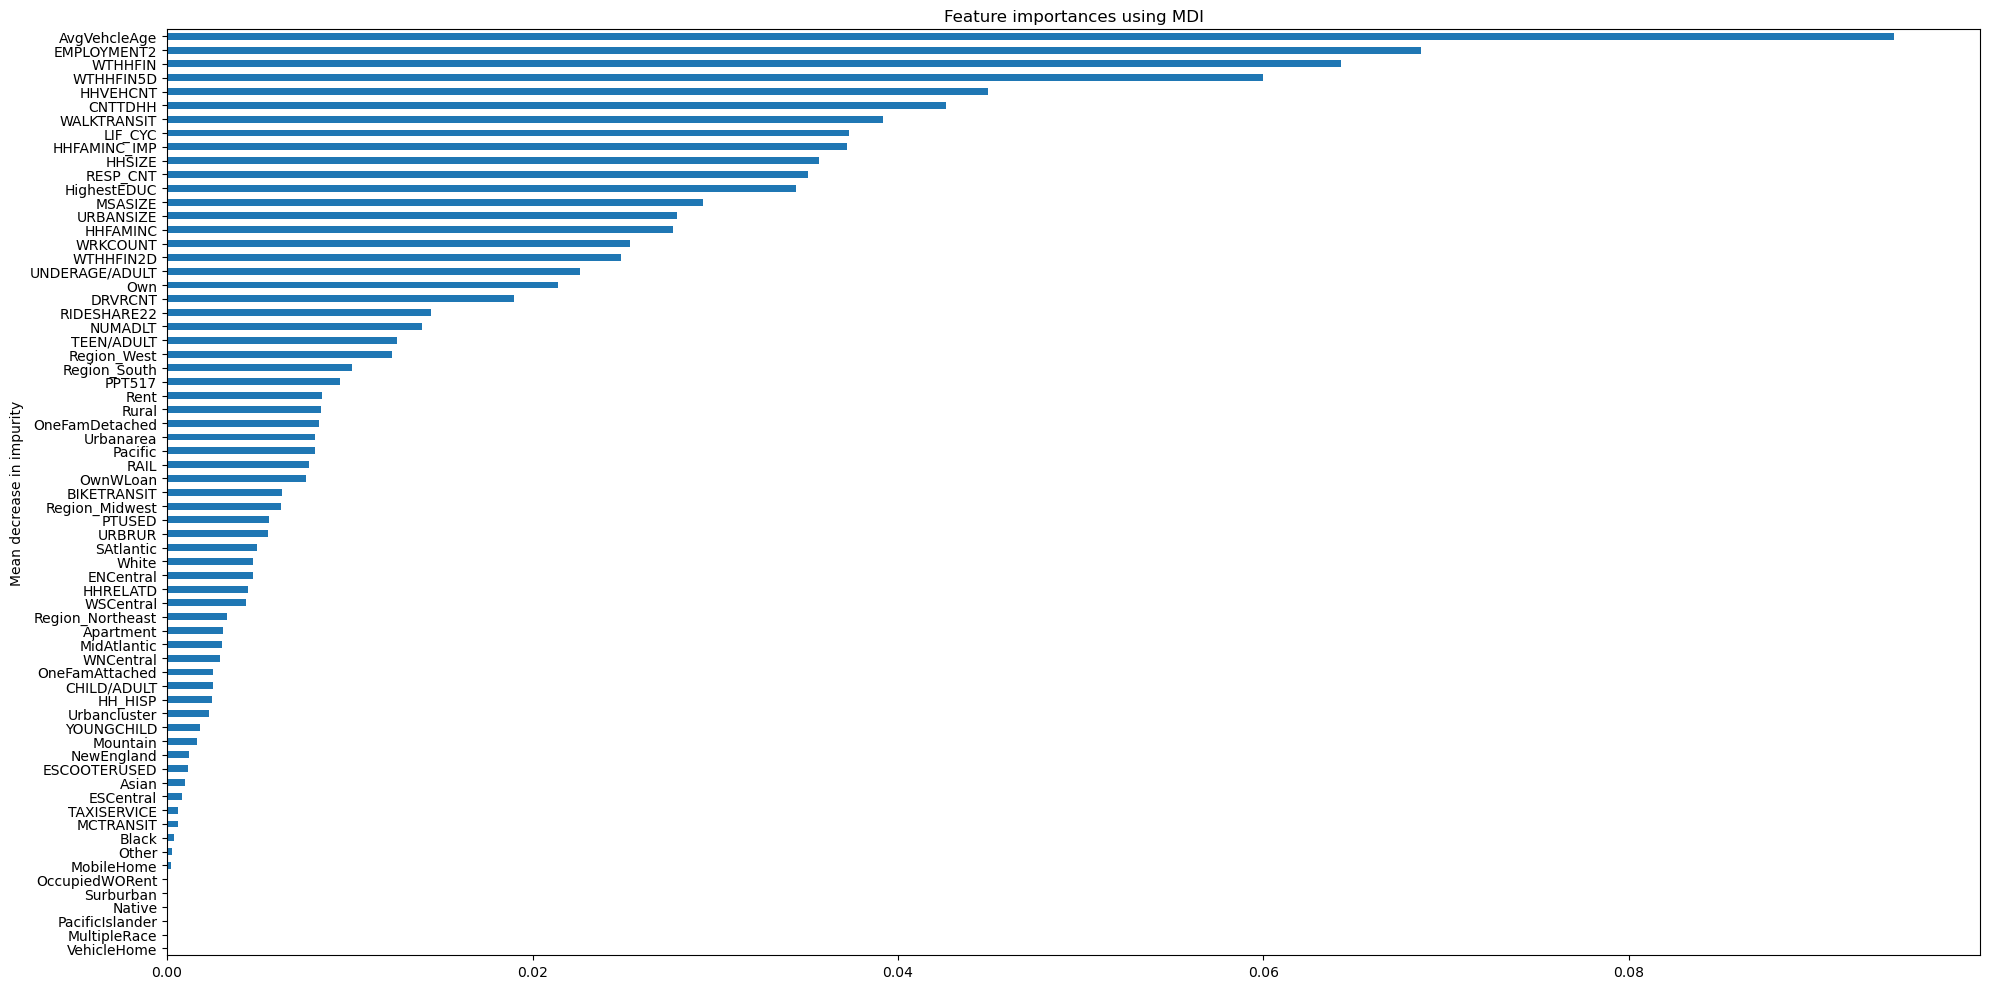

In [74]:
importances = pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(20,10))
ax = importances.plot.barh()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [75]:
result = permutation_importance(
    rfc, x_test, y_test, n_repeats=10, random_state=None, n_jobs=4
)

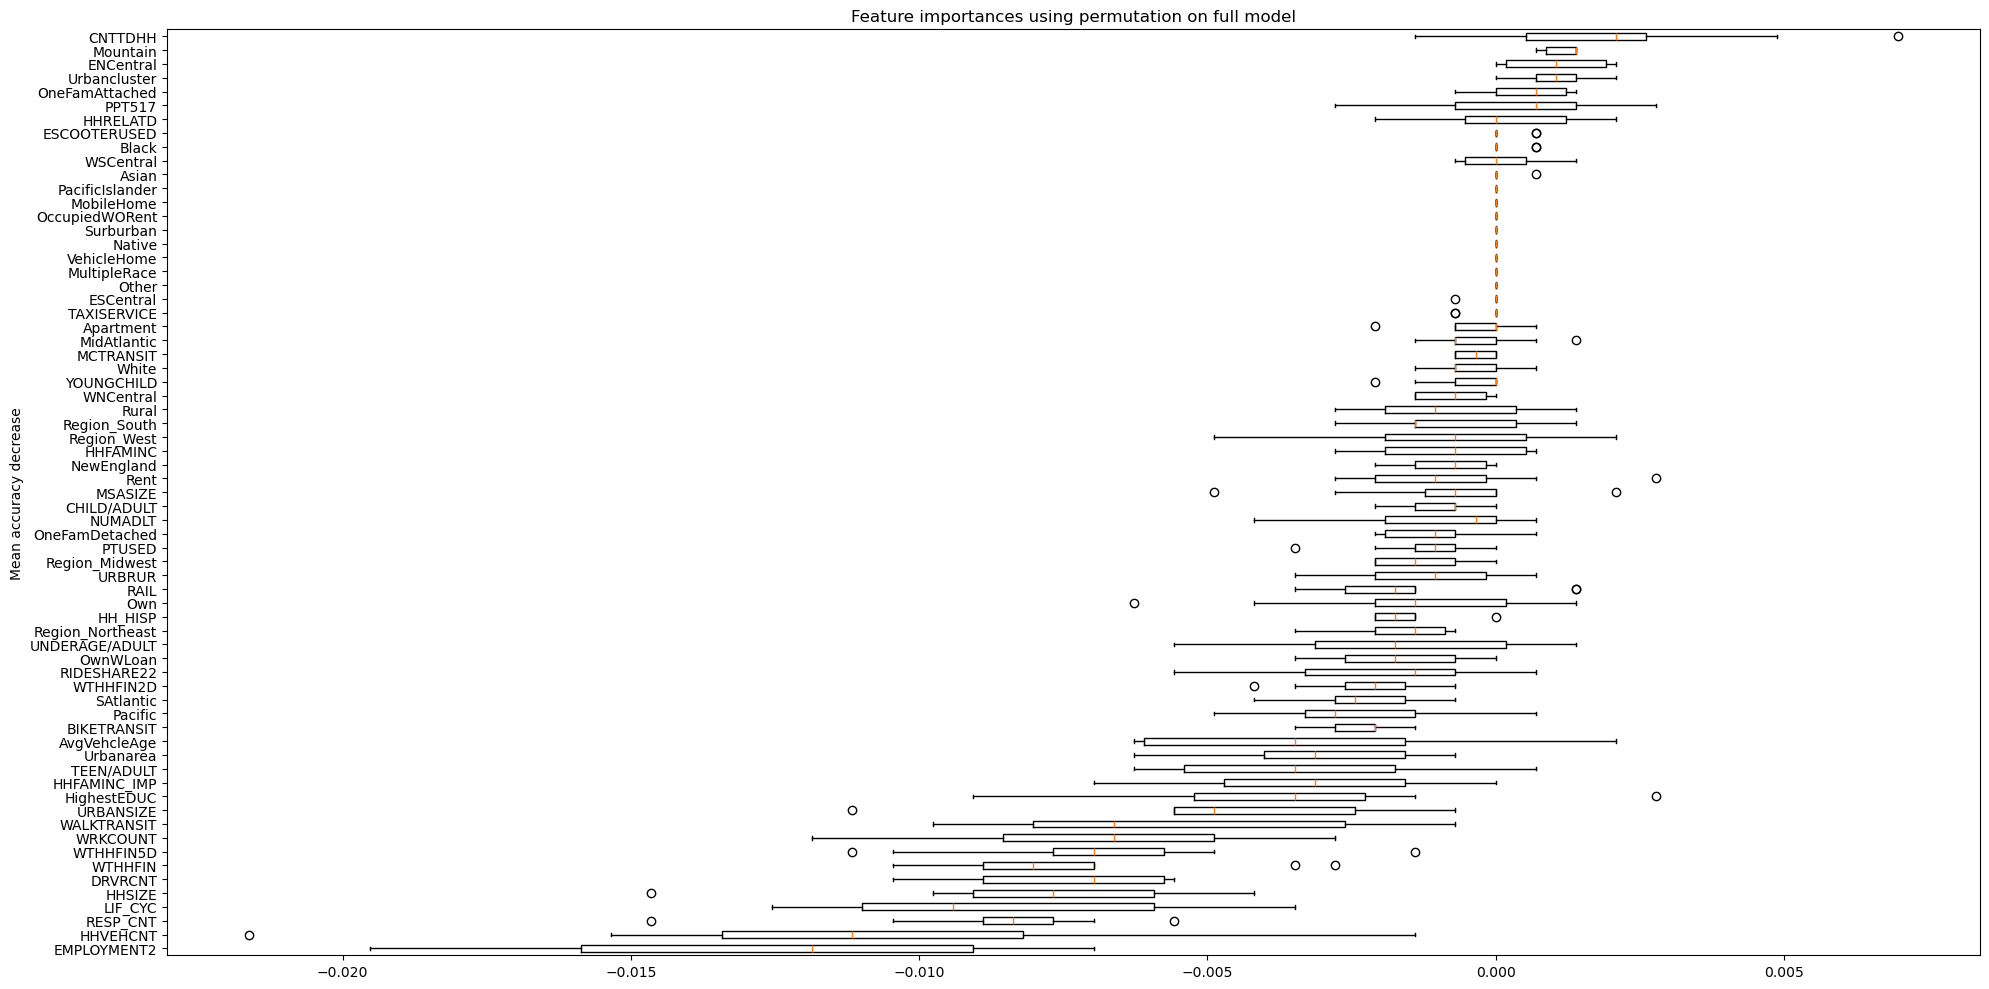

In [76]:
sorted_importances_idx = result.importances_mean.argsort()
#forest_importances = pd.Series(result.importances_mean, index=rfc.feature_names_in_)
forest_importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_test.columns[sorted_importances_idx],
)

fig, ax = plt.subplots(figsize=(20,10))
ax.boxplot(result.importances[sorted_importances_idx].T,
           vert=False,
           labels=x_test.columns[sorted_importances_idx]
           )
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()